# Two-layer original MOSAIKS

## Load utils

In [1]:
import os
import sys
import time
import inspect
import math
import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import timm

# from sklearn.cluster import KMeans


CURR_DIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
PARENT_DIR = os.path.dirname(CURR_DIR)
sys.path.insert(0, "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing")
sys.path.insert(0, "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing/notebooks/mosaiks/")

from dataset.pytorch_dataset import GeoLifeCLEF2022Dataset
from torch.utils.data import random_split, DataLoader
from mosaiks_utils import visualize_3d_patches, visTensor, normalize_patches

/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load GeoLifeCLEF dataset

In [2]:
data_dir ="/network/scratch/s/sara.ebrahim-elkafrawy/small_geo_data" #"/network/scratch/s/sara.ebrahim-elkafrawy/" #   # 
split = "train"
use_ffcv_loader = False
num_species= 17037
bands = ["rgb"] 
batch_size = 1
num_workers = 0

In [3]:
geo_train_dataset = GeoLifeCLEF2022Dataset(
                root=data_dir,
                subset=split,
                use_ffcv_loader=use_ffcv_loader,
                region="both",
                patch_data=bands,
                use_rasters=False,
                patch_extractor=None,
                transform=None,
                target_transform=None,
                opts=None,
            )

geo_train_loader = DataLoader(
                    geo_train_dataset,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    shuffle=True,
                )
trf = torch.nn.Sequential(
    transforms.Resize(size=(224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize((106.9413, 114.8733, 104.5285), (51.0005, 44.8595, 43.2014)),
)

## Define the model: two-layer CNN

In [4]:
# hyperparameters for the model
kernel_size = 7
model_type = 'two_layer_mosaiks_original'
mode = 'whiten' # options ['whiten', 'no_whiten']
num_filters_lyrs = [256, 64] # [512, 128] 
adaptive_pool_sz = 9
num_final_feats= 5184 #10368  # for the first trial: 5184
whiten = True
zca_bias = 0.001
conv_bias = True
save_path = f"/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/"
model_name = f"{model_type}_{kernel_size}_{mode}_filters_{num_filters_lyrs[0]}_adapsz_{adaptive_pool_sz}"
max_iter = 100
random_state = np.random.RandomState(0)

In [5]:
model = nn.Sequential(
         nn.Conv2d(in_channels=3, out_channels=num_filters_lyrs[0], kernel_size=kernel_size, padding='same', bias=conv_bias),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, stride=2),

      nn.Conv2d(in_channels=num_filters_lyrs[0], out_channels=num_filters_lyrs[1], kernel_size=kernel_size, padding='same', bias=conv_bias),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, stride=2),
    
      nn.AdaptiveAvgPool2d(adaptive_pool_sz),
    
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(num_final_feats, 512), #5184
      nn.ReLU(),
      nn.Linear(512, num_species)
      ) 
model(torch.rand((1, 3, 224, 224))).shape

torch.Size([1, 17037])

In [6]:
# # for mosaiks original whiten model
# model_name = "two_layer_mosaiks_original_7_whiten_allGeo_bs32_25eachimage_zcaBias_0.001_bias_True_filters_100_normalized"
# model_path = os.path.join(save_path, model_name+".pt")
# model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [7]:
# print(model_name)
# model_path = os.path.join(save_path, model_name+'.pt')
# model.load_state_dict(torch.load(model_path))

## slicing up the network

In [7]:
model

Sequential(
  (0): Conv2d(3, 100, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(100, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): AdaptiveAvgPool2d(output_size=9)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=5184, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=17037, bias=True)
)

## Manually set the indices of all convolution layers and the afterwards activation layers

In [7]:
# for 2-conv layers
conv_lyrs = [0, 3]
act_lyrs = [1, 4]

# for 4-conv layers
# conv_lyrs = [0, 2, 4, 6]
# act_lyrs = [1, 4, 7, 10]

In [8]:
for name, param in model.named_parameters():
    print(name, '---------------\t', param.shape)

0.weight ---------------	 torch.Size([100, 3, 7, 7])
0.bias ---------------	 torch.Size([100])
3.weight ---------------	 torch.Size([64, 100, 7, 7])
3.bias ---------------	 torch.Size([64])
9.weight ---------------	 torch.Size([512, 5184])
9.bias ---------------	 torch.Size([512])
11.weight ---------------	 torch.Size([17037, 512])
11.bias ---------------	 torch.Size([17037])


## Hooks for activation layers

In [7]:
features_dim = {}
def get_features(name):
    def hook(model, input, output):
        features_dim[name] = output.detach()
    return hook

In [8]:
# for 2-conv layers
model[1].register_forward_hook(get_features('relu_layer_1'))
model[4].register_forward_hook(get_features('relu_layer_4'))


# for 4-conv layers (without nn.AdaptivePool layer)
# model[1].register_forward_hook(get_features('relu_layer_1'))
# model[4].register_forward_hook(get_features('relu_layer_4'))
# model[7].register_forward_hook(get_features('relu_layer_7'))
# model[10].register_forward_hook(get_features('relu_layer_10'))

In [13]:
def get_featuremap_patches(train_dataloader, layer_idx, patch_size, max_patches, random_state):
    '''expects image shape of (width, height, n_channels)
    
    Parameters
    ----------
    train_dataloader: Dataset
                   dataloader for the training dataset to extract from
    
    layer_idx: int
               The index of the current feature map. 
               conv_lyrs[layer_idx] should return the real index of the current weights/parameter 
               
    patch_size: (int, int)
                Receptive field size or width and height of the extracted patch.
                
    max_patches: int
                 The number of extracted patches.
    
    random_state: int
                  Random state for reproducibility 
    Return
    ------
    patches: ndarrah
             final patches of size (max_patches, patch_size, n_channels)
    '''
    all_patches = []
    
    
    for batch in train_dataloader:
        patches, target, meta = batch
        patches['rgb'] = trf(patches['rgb'])
        
        if layer_idx == 0:
            curr_feat_map = patches['rgb'].numpy()
        else:
            output = model(patches['rgb'])
            curr_feat_map = features_dim[f'relu_layer_{act_lyrs[layer_idx-1]}'].numpy()

        if batch_size > 1:
            # grab one image from the batch
            img_idx = random.randint(0, batch_size-1)
            if img_idx >= curr_feat_map.shape[0]:
                img_idx = 0
            curr_feat_map = curr_feat_map[img_idx].transpose((1,2,0))
        else:
            curr_feat_map = curr_feat_map.squeeze(0)
            curr_feat_map = curr_feat_map.transpose((1,2,0))

        # curr_feat_map: expected shape: (width, height, n_channels)
        # output shape: (max_patches, patch_size, n_channels)
        random_patches =  extract_patches_2d(curr_feat_map, 
                                 patch_size, 
                                 max_patches=max_patches,
                                 random_state=random_state)

        random_patches = np.reshape(random_patches, (len(random_patches), -1))

        all_patches.append(random_patches)
    
    return np.concatenate(all_patches, axis=0)

## Apply the K-Means to two conv layers

In [14]:
for layer_idx, relu_idx in enumerate(act_lyrs):
    if layer_idx == len(conv_lyrs):
        break
        
    print(f'for conv layer#{conv_lyrs[layer_idx]}')
    print(f'kmeans for output of relu act layer#{relu_idx}')   
    
    curr_param_idx = conv_lyrs[layer_idx]
    curr_param_sz = model[curr_param_idx].weight.data.shape
    num_clusters = curr_param_sz[0]  # number of output filters/kernels in a layer
    num_ch = curr_param_sz[1]    # number of channels
    patch_size = (curr_param_sz[2], curr_param_sz[3])  # filter/kernel's width and height
    
    if layer_idx == 0:
        max_patches = num_clusters
    else: 
        max_patches = int(num_clusters/4) #int(125000/len(geo_train_loader))   # number of random patches to extract from each image/feature map
    
    print(f'number of random patches from each image: {max_patches}')
    # Step#1: extract random patches  shape:(32064, 147)
    featmap_patches = get_featuremap_patches(geo_train_loader,
                                           layer_idx=layer_idx,
                                             patch_size=patch_size,
                                             max_patches=max_patches,
                                             random_state=random_state)
    
    print(f'num of patches: {len(featmap_patches)}')
    
    # Step#2: pick random patches
    featmap_patches = featmap_patches[np.random.randint(low=0, high=num_filters_lyrs[layer_idx], size=num_filters_lyrs[layer_idx])]
    
    # Step#3: normalize and whiten the patches
    whiten_patches, means, zca_mat = normalize_patches(featmap_patches, zca_bias=zca_bias, whiten=whiten)
    print(f'whiten_patches [min],[max],[mean],[std]: {whiten_patches.min():.3f}, {whiten_patches.max():.3f}, {whiten_patches.mean():.3f}, {whiten_patches.std():.3f}')

    # update the weights of the corresponding conv layer
    print(f'Updating parameter#{curr_param_idx} with size: {curr_param_sz}')
    model[curr_param_idx].weight.data = torch.from_numpy(whiten_patches.reshape(
                                            num_clusters, 
                                            patch_size[0], 
                                            patch_size[1],
                                            num_ch,).transpose(0, 3, 1, 2)
                                        )
#     norm_param = (x - x.mean())/(x.std())
#     model[curr_param_idx].weight.data = norm_param
    
    # save the model
    path = os.path.join(save_path, model_name+".pt")
    torch.save(model.state_dict(), path)
    print(f'Model saved at {path}')

for conv layer#0
kmeans for output of relu act layer#1
number of random patches from each image: 512
num of patches: 1026048
zca bias 0.001
whiten_patches [min],[max],[mean],[std]: -4.539, 3.231, 0.000, 0.554
Updating parameter#0 with size: torch.Size([512, 3, 7, 7])
Model saved at /home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/two_layer_mosaiks_original_7_whiten_zcaBias_0.001_bias_False_filters_512.pt
for conv layer#3
kmeans for output of relu act layer#4
number of random patches from each image: 32



KeyboardInterrupt



In [15]:
def check_weights(weights_data):
    print(f'min: {weights_data.min()}')
    print(f'max: {weights_data.max()}')
    print(f'mean: {weights_data.mean()}')
    print(f'std: {weights_data.std()}')
    print(f'num_complex numbers: {np.iscomplex(weights_data.sum())}')
check_weights(model[0].weight.data.numpy())

min: -4.538667678833008
max: 3.231492042541504
mean: 1.8930556677787536e-08
std: 0.5536641478538513
num_complex numbers: False


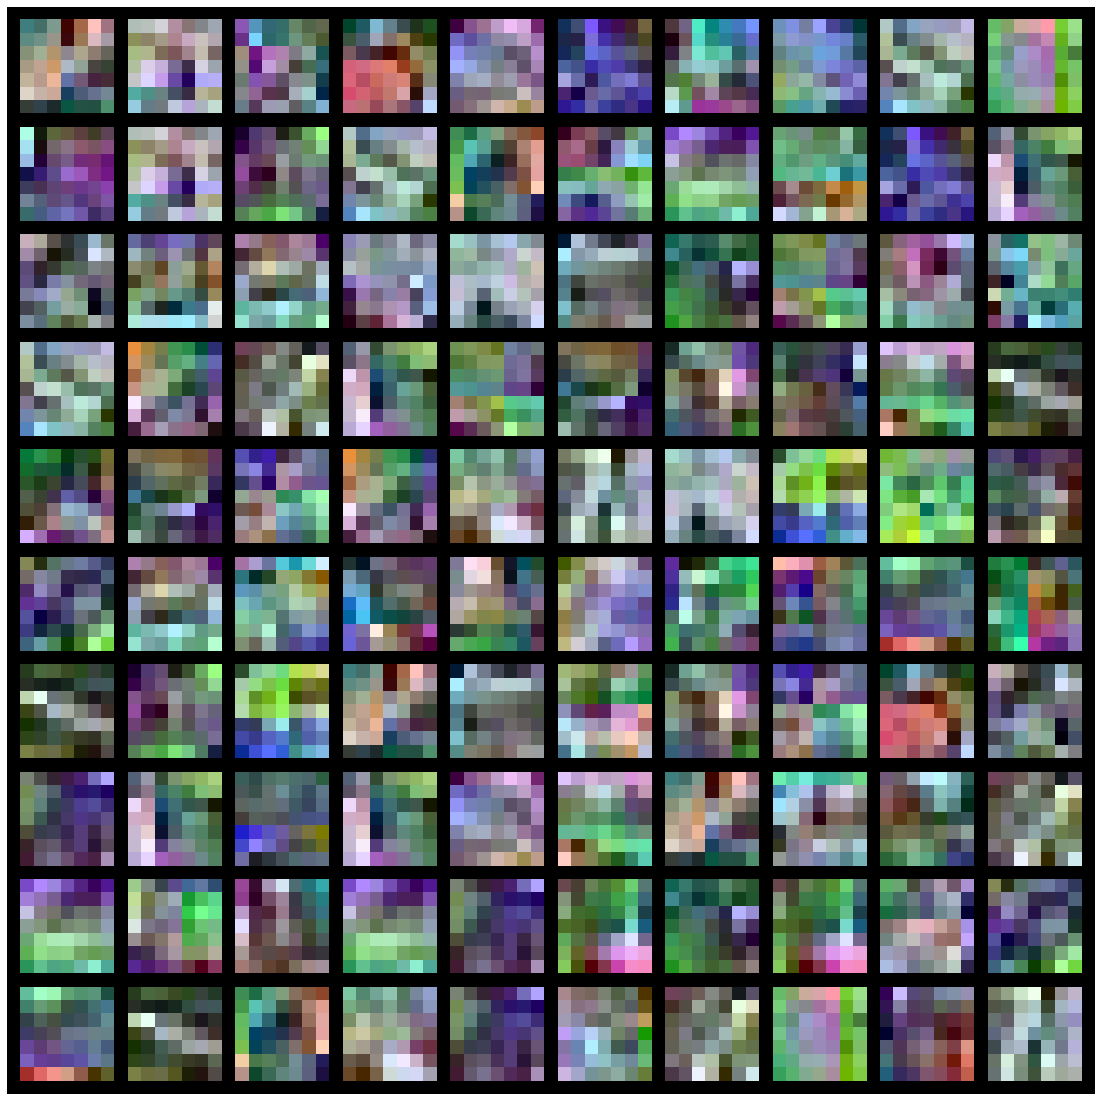

In [14]:
visTensor(model[0].weight.data, ch=0, nrow=int(np.sqrt(num_filters_lyrs[0])), allkernels=False)
plt.axis('off')
plt.ioff()
plt.rcParams['savefig.facecolor']='black'
# plt.savefig(f'../figures/conv1_{model_name}.png')
plt.show()

# Inspect the NaN loss in 2-layer models

In [6]:
# for mosaiks original whiten model
model_type = "two_layer_mosaiks_kmeans"
model_name = f"{model_type}_{kernel_size}_{mode}_filters_{num_filters_lyrs[0]}_adapsz_{adaptive_pool_sz}"
model_path = os.path.join(save_path, model_name+".pt")
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [9]:
model_type = 'kmeans_mosaiks_normalized' #'random_init', 'original_mosaiks' 

In [9]:
model[0].weight.data /= 25
model[3].weight.data /= 25

In [7]:
def plot_histogram(feats_np, name, dim=1):
    feats_np = feats_np.reshape(feats_np.shape[dim],-1)
    plt.title(f'{name}')
    plt.hist(feats_np)
    plt.rcParams['savefig.facecolor']='white'
#     plt.savefig(f'../figures/{name}.png', dpi=150, bbox_inches='tight')
    plt.show()

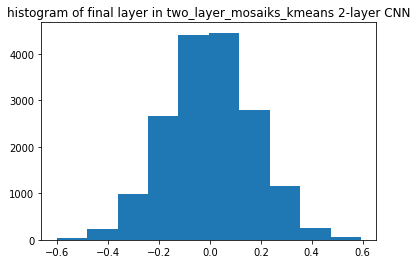

In [10]:
for batch in geo_train_loader:
    patches, target, meta = batch
    patches['rgb'] = trf(patches['rgb'])
    final_output = model(patches['rgb'])
    
#     relu_1_output = features_dim[f'relu_layer_1'].numpy()
#     plot_histogram(relu_1_output, f'histogram of l-relu#1 in {model_type} 2-layer CNN')    
    
#     relu_4_output = features_dim[f'relu_layer_4'].numpy()
#     plot_histogram(relu_4_output, f'histogram of l-relu#4 in {model_type} 2-layer CNN')  
    
    feats_np = final_output.data.numpy()
    plot_histogram(feats_np, f'histogram of final layer in {model_type} 2-layer CNN')
    
    break

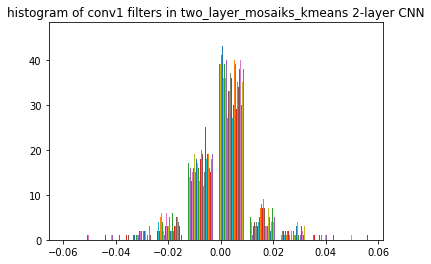

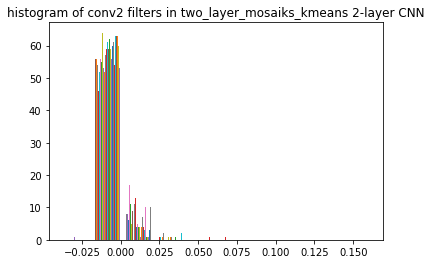

In [12]:
conv1_filters = model[0].weight.data.numpy() #.reshape(num_filters_lyrs[1],-1)
plot_histogram(conv1_filters, f'histogram of conv1 filters in {model_type} 2-layer CNN', dim=0)  

conv2_filters = model[3].weight.data.numpy() #.reshape(num_filters_lyrs[1],-1)
plot_histogram(conv2_filters, f'histogram of conv2 filters in {model_type} 2-layer CNN', dim=0)  

In [11]:
print(model_name)
model_path = os.path.join(save_path, model_name+'_normalized.pt')
torch.save(model.state_dict(), model_path)

two_layer_mosaiks_kmeans_7_whiten_filters_256_adapsz_9


In [8]:
model_type = 'mosaiks_original'

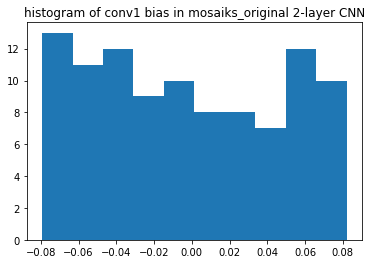

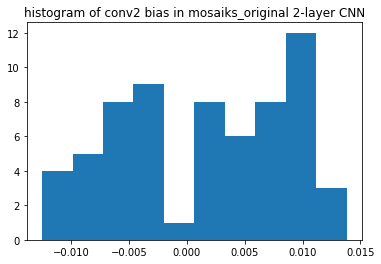

In [11]:
conv1_filters = model[0].bias.data.numpy() #.reshape(num_filters_lyrs[1],-1)
plot_histogram(conv1_filters, f'histogram of conv1 bias in {model_type} 2-layer CNN', dim=0)  

conv2_filters = model[3].bias.data.numpy() #.reshape(num_filters_lyrs[1],-1)
plot_histogram(conv2_filters, f'histogram of conv2 bias in {model_type} 2-layer CNN', dim=0)  